<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/EBM_FIT_UNISIM_M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [804]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.metrics import r2_score

df=pd.read_excel('unisim_hist-m.xlsx')
# df=pd.read_excel('unisim_hist-m.xlsx').iloc[:66,:]
df.tail()

,Date,Press,Np,Gp,Wp,Winj
128,2024-01-31,305,24757936,2793256452,4393983,36864922
129,2024-02-29,306,25022300,2822363056,4583991,37475894
130,2024-03-31,307,25304090,2853787229,4789676,38123794
131,2024-04-30,308,25567400,2883725639,4991816,38702374
132,2024-05-31,309,25832419,2913898931,5206739,39341191


In [805]:
## Parametros escalares (MODSI)
# phi = 0.13
# k = 77
m = 0.0
Rsi = 113.06
Bw = 1.0210
uw = 0.3
cf = 5.3E-05
pb = 210.03
bob = 1.414
co = 0.000162
cw = 47.6E-06
Swi = 0.17 ** 0.35

In [806]:
df["Rp"] = (df["Gp"]/df["Np"]).fillna(0)
df["t"] = (df["Date"]-df["Date"].iloc[0]).astype("int64")/10**9/60/60/24
df["dt"]=df["t"].diff().fillna(0)
df["p_med"]= (df["Press"]+(df["Press"]-df["Press"].diff()).fillna(df["Press"].iloc[0]))/2
df["dp"]= df["Press"].iloc[0]-df["p_med"] ## Dúvida se não deveria ser df["Press"].iloc[0]-df["Press"]
df["pmt"]=((df["Press"].iloc[0]-df["p_med"])*df["dt"]).cumsum()
df.head()

,Date,Press,Np,Gp,Wp,Winj,Rp,t,dt,p_med,dp,pmt
0,2013-05-31,332,0,0,0,0,0.000000,0.0,0.0,332.0,0.0,0.0
1,2013-06-30,332,0,0,0,0,0.000000,30.0,30.0,332.0,0.0,0.0
2,2013-07-31,331,61938,6858068,0,0,110.724725,61.0,31.0,331.5,0.5,15.5
3,2013-08-31,329,124403,13532213,0,0,108.777224,92.0,31.0,330.0,2.0,77.5
4,2013-09-30,328,182423,20112443,0,0,110.251684,122.0,30.0,328.5,3.5,182.5


In [807]:
## PVT functions

def func_bo(p, a, b):
    bo1 = a*p[p<pb]+b
    bo2 = bob+co*bob*(pb-p[p>=pb])
    return np.append(bo1, bo2)

def func_bg(p, a, b):
    return a*p**(b)

def func_rs(p, a, b):
    rs1 = a*p[p<pb]+b
    rs2 = Rsi*np.ones(len(p[p>=pb]))
    return np.append(rs1, rs2)

In [808]:
# EBM
# F/(Eo+mEg+(1+m)Efw)=N+We/(Eo+mEg+(1+m)Efw)
# We = F-N*(Eo+mEg+(1+m)Efw)

# Bt=Bo+(Rsi-Rs)*Bg
# F = Np*(Bt+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rsi-Rs)*Bg+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rp-Rs)*Bg)+(Wp-Winj)*Bw

# Eo= Bt-Bti

# Eg= Boi*(Bg/Bgi-1)

# Efw = Boi*((cf+cw.Swi)/(1-Swi))*∆p
# Efw = Boi*((cf+cw.Swi)/(1-Swi))*(pi-p)

p = df["Press"].values

bo = func_bo(p, 0.0012, 1.1538)
df["Bo"]=bo

bg = func_bg(p, 1.40676, -1.04229)
df["Bg"]=bg

rs = func_rs(p, 0.4655, 15.0114)
df["Rs"]=rs

df["Bt"]=df["Bo"]+(Rsi-df["Rs"])*df["Bg"]
df["F"] = df["Np"]*(df["Bt"]+(df["Rp"]-Rsi)*df["Bg"])+(df["Wp"]-df["Winj"])*Bw
df["Eo"] = df["Bt"]-df["Bt"].iloc[0]
df["Eg"] = df["Bt"].iloc[0]*(df["Bg"]/df["Bg"].iloc[0]-1)
df["Efw"] = df["Bt"].iloc[0]*((cf+cw*Swi)/(1-Swi))*df["dp"]

df.head()

,Date,Press,Np,Gp,Wp,Winj,Rp,t,dt,p_med,dp,pmt,Bo,Bg,Rs,Bt,F,Eo,Eg,Efw
0,2013-05-31,332,0,0,0,0,0.000000,0.0,0.0,332.0,0.0,0.0,1.386061,0.003315,113.06,1.386061,0.000000,0.000000,0.000000,0.000000
1,2013-06-30,332,0,0,0,0,0.000000,30.0,30.0,332.0,0.0,0.0,1.386061,0.003315,113.06,1.386061,0.000000,0.000000,0.000000,0.000000
2,2013-07-31,331,61938,6858068,0,0,110.724725,61.0,31.0,331.5,0.5,15.5,1.386290,0.003325,113.06,1.386290,85383.031591,0.000229,0.004365,0.000118
3,2013-08-31,329,124403,13532213,0,0,108.777224,92.0,31.0,330.0,2.0,77.5,1.386748,0.003346,113.06,1.386748,170732.679461,0.000687,0.013176,0.000471
4,2013-09-30,328,182423,20112443,0,0,110.251684,122.0,30.0,328.5,3.5,182.5,1.386977,0.003357,113.06,1.386977,251296.687673,0.000916,0.017623,0.000825


In [809]:
train = df.copy()
# train = train.drop(["Gp", "Bt", "Bo", "Bg", "Rs", "F", "Eo", "Eg", "Efw", "p", "dt", "dp"], axis=1)

p=train["Press"].values
dp=train["dp"].values
t=train["t"].values
dt=train["dt"].values
F=train["F"].values
Eo=train["Eo"].values
Eg=train["Eg"].values
Efw=train["Efw"].values
npp=train["Np"].values
rp=train["Rp"].values
wp=train["Wp"].values
winj=train["Winj"].values
pmt=train["pmt"].values
p_med=train["p_med"].values

In [810]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We
## m = 0 -> We = F-N*(Eo+Efw)
## dWe/dt = dF/dt-N(dEo/dp+dEfw/dp)*dp/dt
##

## Schilthuis
## We = J∫(p_i-p).dt
## We = J.∑[p_i-p_j+1]*∆t
## We = J.pmt
## pmt = (F-N*(Eo+mEg+(1+m)Efw)/J

# Função objetivo
# def objective(x, Eo, Eg, Efw, F, m, pmt):
#   # print(pmt)
#   N = x[0]  # N é constante
#   J = x[1]  # J é constante
#   pmt_calc = (F - N * (Eo + m * Eg + (1 + m) * Efw)*10**6)/J
#   # print(np.sum((pmt - pmt_calc) ** 2))
#   return np.sum((pmt - pmt_calc) ** 2)

# # Chute inicial para N e J
# x0 = np.array([110] + [1])  # 1 para N e 1 para J

# # Limites para N e J
# bounds = [(110, None)] + [(1, None)]

# # Otimização com restrições
# result = minimize(objective, x0, args=(Eo, Eg, Efw, F, m, pmt), bounds=bounds)

# pmt_calc = (F - result.x[0] * (Eo + m * Eg + (1 + m) * Efw)*10**6)/result.x[1]
# # print(pmt_calc)
# N_est = result.x[0]*10**6
# J_est = result.x[1]
# We_est = J_est*pmt

# print(f"Estimativa de N: {N_est}")
# print(f"Estimativas de J: {J_est}")
# print(f"Estimativas de We: {We_est}")

# plt.scatter(t, pmt, label="Data", color="blue")
# plt.plot(t, pmt_calc, label="Fit", color="red", linewidth=3)
# plt.legend(fontsize='small')
# plt.xlabel("t")
# plt.ylabel("pmt")
# plt.show()

In [811]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We

# Função objetivo
def objective(x, Eo, Eg, Efw, F, m):
    N = x[0]  # N é constante
    We = x[1:]  # We para cada ponto no tempo
    F_calc = N * (Eo + m * Eg + (1 + m) * Efw)*10**6 + We
    # print(np.sum((F - F_calc) ** 2))
    return np.sum((F - F_calc) ** 2)

# Chute inicial para N e We para cada t
x0 = np.array([1] + [0] * len(F))  # 1 para N e 1 para cada We(t)

# Limites para N e We(t), ambos maiores ou iguais a zero.
bounds = [(1, None)] + [(0, None) for _ in F]

# Restrições para garantir que We(t+1) >= We(t)
def constraint_We(We, i):
    return We[i + 1] - We[i]

constraints = []
for i in range(len(F) - 1):
    constraints.append({'type': 'ineq', 'fun': lambda x, i=i: constraint_We(x[1:], i)})

# Otimização com restrições
result = minimize(objective, x0, args=(Eo, Eg, Efw, F, m), bounds=bounds, constraints=constraints)
##, constraints=constraints

N_est = result.x[0]*10**6
We_est = result.x[1:]

print(f"Estimativa de N: {N_est}")
print(f"Estimativas de We: {We_est}")

Estimativa de N: 125171493.08824582
Estimativas de We: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


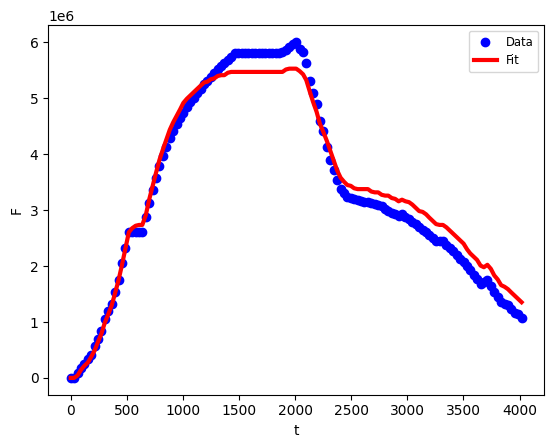

In [812]:
plt.scatter(t, F, label="Data", color="blue")
plt.plot(t, N_est * (Eo + m * Eg + (1 + m) * Efw) + We_est, label="Fit", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("F")
plt.show()

In [813]:
## Schilthuis
## We = J∫(p_i-p).dt
## We = J.∑[p_i-p_j+1]*∆t
## p_j+1_ = [p_j+p_j+1]/2
## ∆t = t_j+1-t_j
## j = 0....n-1

#Aquífero Schilthuis
def we_pred1(t, J):
    dt=t-np.roll(t,1)
    p_med=(p+np.roll(p,1))/2
    pmt = ((p[0]-p_med[2:])*dt[2:]).cumsum()
    return np.append(np.zeros(2), J*pmt[0:len(t)])

# Chute inicial para J
initialGuess1=[0]

# Ajuste da curva
popt1,pcov1 = curve_fit(we_pred1, t, We_est, initialGuess1)

fittedData1 = we_pred1(t, *popt1)
r2_1 = r2_score(We_est, fittedData1)
print(popt1, r2_1)

[0.] 1.0


In [814]:
## Hurst Mod.
## We = C.∫[(pi-p)/ln(at)].dt
## We = C.∑[(pi-pj+1)/ln(at)]*∆t
## p_j+1_ = [p_j+p_j+1]/2
## ∆t = t_j+1-t_j
## j = 0....n-1

##Aquífero Hurst Modificado
# def we_pred2(t, C, a):
#     dt=t-np.roll(t,1)
#     p_med=(p+np.roll(p,1))/2
#     pmt = (((p[0]-p_med[1:])*dt[1:])/np.log(a*t[1:])).cumsum()
#     pmt[pmt < 0] = 0
#     return np.append(np.zeros(1), C*pmt[0:len(t)])

# # Chute inicial para C e a
# initialGuess2=[15,0.01]

# # Ajuste da curva
# popt2,pcov2 = curve_fit(we_pred2, t, We_est, initialGuess2)

# fittedData2 = we_pred2(t, *popt2)
# r2_2 = r2_score(We_est, fittedData2)
# print(popt2, r2_2)

In [815]:
## Fetkovich
## ∆Wen = (Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## Wen = Wen-1+(Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## pan-1 = pi.[1-Wen-1/Wei]
## pn = [pn-1+pn]/2
## ∆t = t_j+1-t_j
## n = 1....n

##Aquífero Fetkovich
# def we_pred3(t, Wei, J):
#     dt=t-np.roll(t,1)
#     p_med=(p+np.roll(p,1))/2
#     we3=np.zeros(len(p))
#     pa_med=np.zeros(len(p))
#     for i in range(len(p)):
#         if p[i] >= p[0]:
#             dt[i] = 0
#             p_med[i] = p[0]
#             we3[i] = 0
#             pa_med[i] = p[0]
#         else:
#             dt[i]=t[i]-t[i-1]
#             p_med[i]=(p[i]+p[i-1])/2
#             we3[i]=we3[i-1]+(Wei/p[0])*(pa_med[i-1]-p_med[i])*(1-np.exp(-J*p[0]*dt[i]/Wei))
#             pa_med[i]=p[0]*(1-we3[i]/Wei)
#     return we3

# # Chute inicial para Wei e J
# initialGuess3=[1E6,1]

# # Ajuste da curva
# popt3,pcov3 = curve_fit(we_pred3, t, We_est, initialGuess3)

# fittedData3 = we_pred3(t, *popt3)
# r2_3 = r2_score(We_est, fittedData3)
# print(popt3, r2_3)

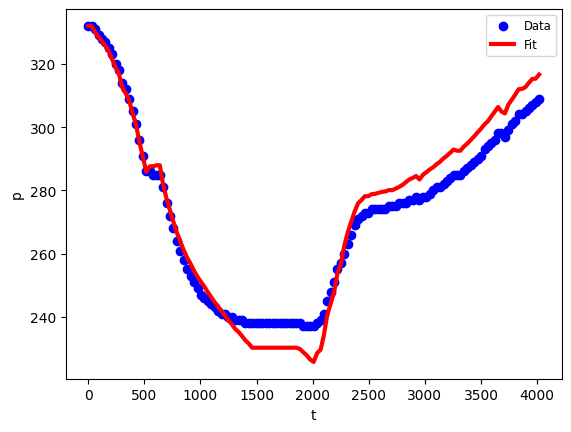

[332.         332.         330.03356601 328.40789264 327.23185825
 325.5998927  324.06030269 321.3612955  318.84656891 316.93923199
 312.51481606 310.77312225 308.39589924 304.53066694 300.80542778
 295.2618657  290.57168866 285.89711595 287.61194622 287.61194622
 287.95491333 287.95491333 281.62310005 277.27639677 273.56099218
 269.98281294 266.60129744 263.71691034 261.049623   258.61695302
 256.73908948 254.51965634 252.61914037 251.12241187 249.61834911
 247.88214467 246.23375107 244.71188902 243.26474961 241.81947755
 240.54751714 238.91409983 237.72315334 236.20677944 235.20510607
 234.04332076 232.62203283 231.61762161 230.27127856 230.27127856
 230.27127856 230.27127856 230.27127856 230.27127856 230.27127856
 230.27127856 230.27127856 230.27127856 230.27127856 230.27127856
 230.27127856 230.27127856 229.8456227  228.78699078 227.84441305
 226.50624389 225.77623189 228.57620902 229.64602596 234.02051182
 240.69365285 244.11955513 247.86520072 253.73534806 256.73872499
 262.64265

In [816]:
# Simulação Histórico de Pressão x Tempo

p_prev=np.zeros(len(t))
we_prev=np.zeros(len(t))
pimt=np.zeros(len(t))
# alpha = 0.99

def f_sch(pn, i):
    pmed=(pn+p[i-1])/2
    pimt[i]=(pimt[i-1]+((p[0]-pmed)*(t[i]-t[i-1]))).reshape(())
    Sch=popt1[0]*pimt[i]
    return Sch

def f_ebm(pn, i):
    pmed=(pn+p[i-1])/2
    Bo = func_bo(pn, 0.0012, 1.1538)
    Bg = func_bg(pn, 1.40676, -1.04229)
    F=npp[i]*(Bo+(rp[i]-Rsi)*Bg)+(wp[i]-winj[i])*Bw
    Eo=Bo-bo[0]
    Efw=bo[0]*((cf+cw*Swi)/(1-Swi))*(p[0]-pmed)
    EBM=F-N_est*(Eo+Efw)
    return EBM

for i in range(len(t)):
    if i < 2:
        p_prev[i]=p[0]
        we_prev[i]=0
        pimt[i]=0
    else:
        def f_obj(pn):
            Aquif=f_sch(pn, i)
            EBM=f_ebm(pn, i)
            return(EBM-Aquif)
        const = {'type':'eq', 'fun': f_obj}
        result=minimize(f_obj, p[i], constraints=const)
        p_prev[i]=result.x[0]

plt.scatter(t, p, label="Data", color="blue")
plt.plot(t, p_prev, label="Fit", color="red", linewidth=3)
# plt.plot(t, df["Press_b"], label="Benchmark", color="black", linewidth=2, linestyle='--')
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p")
plt.show()

print(p_prev)